In [1]:
from Simulation.helper_functions import mol_to_traj, get_dihedrals_by_name
import mdtraj
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from Simulation.helper_functions import kjmol_to_prop, SOLVENT_DICT
from matplotlib import cm

def get_color_from_sd(sd):
    return cm.RdBu(sd/80)

# I1

## Define Functions

In [2]:
from Simulation.helper_functions import calculate_entropy_from_frequencies
def normal_modes(
    hessian_matrix=None, realAtomIdxs=None, masses=None
):
    """
    Adapted from https://leeping.github.io/forcebalance/doc/html/api/openmmio_8py_source.html

    OpenMM Normal Mode Analysis
    Since OpenMM doesnot provide a Hessian evaluation method, we used finite difference on forces

    Parameters
    ----------
    shot: int
        The frame number in the trajectory of this target
    optimize: bool, default True
        Optimize the geometry before evaluating the normal modes

    Returns
    -------
    freqs: np.array with shape (3N - 6) x 1, N = number of "real" atoms
        Harmonic frequencies, sorted from smallest to largest, with the 6 smallest removed, in unit cm^-1
    normal_modes: np.array with shape (3N - 6) x (3N), N = number of "real" atoms
        The normal modes corresponding to each of the frequencies, scaled by mass^-1/2.
    """

    # Mass weight hessian

    mass_weighted_hessian = np.zeros(hessian_matrix.shape)
    for i in range(len(realAtomIdxs) * 3):
        for j in range(len(realAtomIdxs) * 3):
            mass_weighted_hessian[i][j] = hessian_matrix[i][j] / np.sqrt(masses[i//3] * masses[j//3])

    # step 1: build a full hessian matrix
    noa = len(realAtomIdxs)
    # step 2: diagonalize the hessian matrix
    eigvals, eigvecs = np.linalg.eigh(mass_weighted_hessian)
    # step 3: convert eigenvalues to frequencies
    coef = 0.5 / np.pi * 33.3564095  # 10^12 Hz => cm-1
    negatives = (eigvals >= 0).astype(int) * 2 - 1  # record the negative ones
    freqs = np.sqrt(eigvals + 0j) * coef * negatives
    # step 4: convert eigenvectors to normal modes
    # re-arange to row index and shape
    normal_modes = eigvecs.T.reshape(noa * 3, noa, 3)
    # step 5: Remove mass weighting from eigenvectors
    massList = np.array(masses) # unit in dalton
    for i in range(normal_modes.shape[0]):
        mode = normal_modes[i]
        mode /= np.sqrt(massList[:, np.newaxis])
        mode /= np.linalg.norm(mode)
    # step 5: remove the 6 freqs with smallest abs value and corresponding normal modes
    n_remove = 5 if len(realAtomIdxs) == 2 else 6
    larger_freq_idxs = np.sort(np.argpartition(np.abs(freqs), n_remove)[n_remove:])
    # larger_freq_idxs = np.sort(np.argpartition(np.abs(freqs), n_remove))[n_remove:]
    freqs = freqs[larger_freq_idxs]
    normal_modes = normal_modes[larger_freq_idxs]
    return freqs, normal_modes

def get_cluster_asignments_ordered(
    traj,
    energies,
    thresh=0.05,
    energy_thresh=2,
    verbose=False,
    additional_requirements=None,
    permutations=None,
    mol=None,
    selection=None,
):
    if selection is None:
        selection = traj.top.select("element != H")
    if permutations is None:
        permutations = [selection]

    ordered_traj = mdtraj.Trajectory(traj.xyz[energies.argsort()], traj.top)
    ordered_energies = energies[energies.argsort()]
    cluster_center_traj = ordered_traj[0]
    cluster_energies = [energies[energies.argsort()][0]]

    index_sort_mapping = energies.argsort()

    indices = [index_sort_mapping[0]]
    if additional_requirements is not None:
        additional_requirements_sorted = additional_requirements[energies.argsort()]
        cluster_additional_requirements = [additional_requirements_sorted[0]]

    for i in np.arange(1, ordered_traj.n_frames):
        rmsds = np.zeros((len(permutations), len(cluster_center_traj)), dtype=np.float)
        for p, permutation in enumerate(permutations):
            rmsds[p] = mdtraj.rmsd(
                cluster_center_traj,
                ordered_traj,
                i,
                atom_indices=selection,
                ref_atom_indices=permutation,
            )
        rmsd = np.min(rmsds, axis=0)
        if np.min(rmsd) < thresh:
            if np.all(
                np.abs(
                    (np.array(cluster_energies)[rmsd < thresh] - ordered_energies[i])
                )
                > energy_thresh
            ) or (
                (additional_requirements is not None)
                and (
                    additional_requirements_sorted[i]
                    not in np.array(cluster_additional_requirements)[rmsd < thresh]
                )
            ):
                cluster_center_traj += ordered_traj[i]
                indices.append(index_sort_mapping[i])
                cluster_energies.append(ordered_energies[i])
                if additional_requirements is not None:
                    cluster_additional_requirements.append(
                        additional_requirements_sorted[i]
                    )
        else:
            cluster_center_traj += ordered_traj[i]
            indices.append(index_sort_mapping[i])
            cluster_energies.append(ordered_energies[i])
            if additional_requirements is not None:
                cluster_additional_requirements.append(
                    additional_requirements_sorted[i]
                )

    if mol is not None:
        new_mol = Chem.Mol(mol)
        new_mol.RemoveAllConformers()
        for i in indices:
            new_mol.AddConformer(mol.GetConformer(int(i)), assignId=True)

        return cluster_center_traj, cluster_energies, new_mol

    return cluster_center_traj, cluster_energies

## Load Data

In [3]:
figure_location = "/fileserver/birch/birch1/kpaul/pine8/QMGNN/manuscript/plots"

In [4]:
smiles = "COCCO"
functional = "_SMD_B3LYP_TZVP"
# functional = "
folder = f"/fileserver/birch/birch1/kpaul/pine8/QMGNN/Methoxy_results/Methoxy_start_orca_min_hessian_no_mpi{functional}_f025/"
nconfs = 1

solvent_mapping = {
    "water": "tip3p",
    "chloroform": "Chloroform",
    "methanol": "Methanol",
    "dmso": "DMSO",
    "benzene": "Benzol",
    "thf": "THF",
    "acetonitrile": "acetonitrile",
    "pyridine": "pyridine",
    "acetone": "acetone",
    "diethylether": "Diethylether",
    "dioxane": "14dioxane",
    "hexane": "Hexan",
}

gnn_results_ORCA_ASE = {}
gnn_results_ORCA = {}
smd_results_ORCA = {}
gnn_smd_results_ORCA = {}
cosmors_results_ORCA = {}

for solvent in solvent_mapping.keys():
    try:
        def get_results(folder,solvent,nconfs,method):
            free_energies = []
            positions = []
            frequencies = []

            mol = Chem.MolFromSmiles(smiles)
            mol = Chem.AddHs(mol)
            AllChem.EmbedMolecule(mol)
            traj = mol_to_traj(mol)
            
            for seed in range(256):
                try:
                    results = np.load(f"{folder}/{solvent}_{seed}.npy",allow_pickle=True)
                except Exception as e:
                    print(e)
                    continue

                if method == "gnn_orca":
                    free_energies.append(results[0][3])
                    positions.append(results[0][0])
                elif method == "cosmors_orca":
                    hessian = results[0][4]*96.485332
                    masses = np.array([atom.GetMass() for atom in mol.GetAtoms()]).round(0)
                    idices = [atom.GetIdx() for atom in mol.GetAtoms()]
                    freqs, nm = normal_modes(hessian, idices, masses)
                    if np.sum(np.iscomplex(freqs)) != 0: # Complex Frequency
                        continue
                    free_energies.append(results[0][2])
                    positions.append(results[0][0])
                    # Add Frequencies
                    frequencies.append(freqs)

                elif method == "smd_orca":
                    hessian = results[0][4]*96.485332
                    masses = np.array([atom.GetMass() for atom in mol.GetAtoms()]).round(0)
                    idices = [atom.GetIdx() for atom in mol.GetAtoms()]
                    freqs, nm = normal_modes(hessian, idices, masses)
                    if np.sum(np.iscomplex(freqs)) != 0: # Complex Frequency
                        continue
                    frequencies.append(freqs)
                    free_energies.append(results[0][1])
                    positions.append(results[0][0])
                elif method == "gnn_orca_ase":
                    pos = results[0][8]

                    hessian = results[0,10]*96.485332 + results[0,11]
                    masses = np.array([atom.GetMass() for atom in mol.GetAtoms()]).round(0)
                    idices = [atom.GetIdx() for atom in mol.GetAtoms()]
                    freqs, nm = normal_modes(hessian, idices, masses)
                    # test if any freqs is complex
                    if np.sum(np.iscomplex(freqs)) != 0: # Complex Frequency
                        continue
                    vib_entropy = calculate_entropy_from_frequencies(freqs)
                    free_energy = results[0,12] - vib_entropy
                    positions.append(results[0][8])
                    free_energies.append(free_energy)
                    frequencies.append(freqs)
                elif method == "gnn_smd_orca":
                    free_energies.append(results[0][6])
                    positions.append(results[0][0])

            energies = np.array(free_energies)
            energies[energies < np.median(energies[energies != np.inf])*1.5] = np.inf
            traj.xyz = np.array(positions)[energies != np.inf]
            energies = energies[energies != np.inf]

            # all atom RMSD
            selection = [traj.top.select("all")]
            print(selection)
            cluster_traj, cluster_energies = get_cluster_asignments_ordered(traj=traj,energies=energies,energy_thresh=100,thresh=0.05,permutations=selection,selection=selection[0])

            # get indices of cluster_energies based on energies
            indices = [np.argwhere(energies == e)[0][0] for e in cluster_energies]
            if len(frequencies) > 0:
                frequencies = np.array(frequencies)[indices]
            dh = get_dihedrals_by_name(cluster_traj, "O1","C2","C3","O2").flatten()
            return (dh, cluster_energies, cluster_traj,frequencies)

        gnn_results_ORCA_ASE[solvent] = get_results(folder,solvent,nconfs,"gnn_orca_ase")
        gnn_results_ORCA[solvent] = get_results(folder,solvent,nconfs,"gnn_orca")
        smd_results_ORCA[solvent] = get_results(folder,solvent,nconfs,"smd_orca")
        gnn_smd_results_ORCA[solvent] = get_results(folder,solvent,nconfs,"gnn_smd_orca")
        cosmors_results_ORCA[solvent] = get_results(folder,solvent,nconfs,"cosmors_orca")
    except Exception as e:
        print(e)
        continue

[Errno 2] No such file or directory: '/fileserver/birch/birch1/kpaul/pine8/QMGNN/Methoxy_results/Methoxy_start_orca_min_hessian_no_mpi_SMD_B3LYP_TZVP_f025//water_255.npy'
[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])]
[Errno 2] No such file or directory: '/fileserver/birch/birch1/kpaul/pine8/QMGNN/Methoxy_results/Methoxy_start_orca_min_hessian_no_mpi_SMD_B3LYP_TZVP_f025//water_255.npy'
[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])]


/tmp/ipykernel_2471288/1387108298.py:87: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  rmsds = np.zeros((len(permutations), len(cluster_center_traj)), dtype=np.float)


[Errno 2] No such file or directory: '/fileserver/birch/birch1/kpaul/pine8/QMGNN/Methoxy_results/Methoxy_start_orca_min_hessian_no_mpi_SMD_B3LYP_TZVP_f025//water_255.npy'
[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])]
[Errno 2] No such file or directory: '/fileserver/birch/birch1/kpaul/pine8/QMGNN/Methoxy_results/Methoxy_start_orca_min_hessian_no_mpi_SMD_B3LYP_TZVP_f025//water_255.npy'
[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])]
[Errno 2] No such file or directory: '/fileserver/birch/birch1/kpaul/pine8/QMGNN/Methoxy_results/Methoxy_start_orca_min_hessian_no_mpi_SMD_B3LYP_TZVP_f025//water_255.npy'
[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])]
[Errno 2] No such file or directory: '/fileserver/birch/birch1/kpaul/pine8/QMGNN/Methoxy_results/Methoxy_start_orca_min_hessian_no_mpi_SMD_B3LYP_TZVP_f025//chloroform_255.npy'
[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])]
[Errno 2] No such file or directory: '/fileserver/birch/birch1/

/localhome/kpaul/.conda/envs/QMGNN_test/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/localhome/kpaul/.conda/envs/QMGNN_test/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [5]:
cosmors_results_ORCA.keys(), gnn_results_ORCA.keys()

(dict_keys(['water', 'chloroform', 'methanol', 'dmso', 'benzene', 'thf', 'acetonitrile', 'pyridine', 'acetone', 'diethylether', 'dioxane']),
 dict_keys(['water', 'chloroform', 'methanol', 'dmso', 'benzene', 'thf', 'acetonitrile', 'pyridine', 'acetone', 'diethylether', 'dioxane']))

## Experimental J couplings

In [6]:
DMSO = (3.329792,3.350559)
Methanol = (3.476629,3.496138)
Acetone = (3.411923,3.432143)
Chloroform = (3.499005,3.517427)
Benzene = (3.113495,3.132309)
Acetonitrile = (3.414090,3.433687)
Water = (3.479675,3.498249)
Pyridine = (3.581476,3.601787)
THF = (3.383884,3.404144)
smiles = "COCCO"
reference_J_couplings_n = {"Methanol":(Methanol[1]-Methanol[0])*500,"acetone":(Acetone[1]-Acetone[0])*500,"Chloroform":(Chloroform[1]-Chloroform[0])*500,"Benzol":(Benzene[1]-Benzene[0])*500,"acetonitrile":(Acetonitrile[1]-Acetonitrile[0])*500,"tip3p":(Water[1]-Water[0])*500,"pyridine":(Pyridine[1]-Pyridine[0])*500,"THF":(THF[1]-THF[0])*500,"DMSO":(DMSO[1]-DMSO[0])*500}
reference_J_couplings = {"methanol":(Methanol[1]-Methanol[0])*500,"acetone":(Acetone[1]-Acetone[0])*500,"chloroform":(Chloroform[1]-Chloroform[0])*500,"benzene":(Benzene[1]-Benzene[0])*500,"acetonitrile":(Acetonitrile[1]-Acetonitrile[0])*500,"water":(Water[1]-Water[0])*500,"pyridine":(Pyridine[1]-Pyridine[0])*500,"thf":(THF[1]-THF[0])*500,"dmso":(DMSO[1]-DMSO[0])*500}

## Predict trans population

In [7]:
exp_J_sum = [np.sum(ref) for ref in reference_J_couplings.values()]
color = [get_color_from_sd(SOLVENT_DICT[solvent]["dielectric"]) for solvent in reference_J_couplings_n.keys()]
names = [solvent for solvent in reference_J_couplings_n.keys()]

def get_populations(solvent_results):

    min_populations = []
    for solvent in reference_J_couplings.keys():
        res = solvent_results[solvent]
        gnn_dh = res[0]
        cluster_energies = res[1]  
        selection = (gnn_dh < 2.1) & (gnn_dh > -2.1)
        min_pre = np.sum(kjmol_to_prop(np.array(cluster_energies)-np.min(cluster_energies))[selection.flatten()])
        min_populations.append(1-min_pre)
    
    return min_populations

gnn_results_orca_ase_populations = get_populations(gnn_results_ORCA_ASE)
gnn_results_orca_populations = get_populations(gnn_results_ORCA)
smd_results_orca_populations = get_populations(smd_results_ORCA)
gnn_smd_results_orca_populations = get_populations(gnn_smd_results_ORCA)
cosmors_results_orca_populations = get_populations(cosmors_results_ORCA)

## Plot Results

In [8]:
def fit_JHHs(populations,Js):
    from scipy.optimize import curve_fit

    def func(x,Jg,Jt):

        return (Jg+Jt)*x + (3*Jg+Jt)/2 *(1-x)
    popt, pcov = curve_fit(func, populations, Js)

    return popt

/tmp/ipykernel_2471288/2820222480.py:6: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.2)


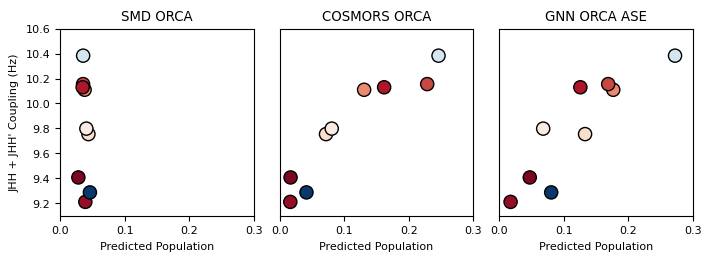

In [9]:
plt.rcParams.update({'font.size': 8})
fig, axd = plt.subplot_mosaic([["SMD ORCA","COSMORS ORCA","GNN ORCA ASE"]],figsize=(7,2.5),constrained_layout=True,empty_sentinel="EMPTY")
# set font size

# set vertical distance between subplots
plt.subplots_adjust(hspace=0.2)

def plot_comp(ax,min_populations):
    ax.scatter(min_populations,exp_J_sum,c=color,s=90,marker='o',edgecolors='black')
    # ax.errorbar(min_populations,Js,xerr=populations_std,fmt='o',color='black',zorder=0)
    ax.set_xlabel("Predicted Population of trans rotamer")
    ax.set_ylabel("JHH + JHH' Coupling (Hz)")
    # ax.set_title("GNN")

    # for i in range(len(min_populations)):

    #     shifty=0.015
    #     shiftx=0.002
    #     if names[i] == "acetonitrile":
    #         shifty = -0.095
    #         shiftx = -0.001
    #     if names[i] == "acetone":
    #         shifty = 0.075
    #         shiftx = 0.005
    #     if names[i] == "THF":
    #         shifty = 0.02
    #         # shiftx = -0.014
    #     if names[i] == "pyridine":
    #         shiftx = -0.00
    #         # shifty = -0.12
    #     if names[i] == "DMSO":
    #         shifty = 0.05
    #         shiftx = -0.001
    #     ax.text(min_populations[i]+0.002+shiftx,exp_J_sum[i]+shifty,SOLVENT_DICT[names[i]]["nice_name"],fontsize=8)

plot_comp(axd["GNN ORCA ASE"],gnn_results_orca_ase_populations)
plot_comp(axd["SMD ORCA"],smd_results_orca_populations)
plot_comp(axd["COSMORS ORCA"],cosmors_results_orca_populations)

axd["GNN ORCA ASE"].set_title("GNN ORCA ASE")
axd["SMD ORCA"].set_title("SMD ORCA")
axd["COSMORS ORCA"].set_title("COSMORS ORCA")

for ax in axd.values():
    ax.set_xlabel("Predicted Population")
    ax.set_ylabel("JHH + JHH' Coupling (Hz)")
    ax.set_xlim(0,0.3)
    ax.set_ylim(9.1,10.6)
    ax.get_yaxis().set_visible(False)
axd["SMD ORCA"].get_yaxis().set_visible(True)

# fig.savefig("Draft_Figures/populations_BP86_SVP_JHH.pdf",bbox_inches='tight')
fig.savefig(f"{figure_location}/populations_B3LYP_TZVP_JHH.pdf",bbox_inches='tight')

### inverse

In [332]:
reference_J_couplings.keys()

dict_keys(['methanol', 'acetone', 'chloroform', 'benzene', 'acetonitrile', 'water', 'pyridine', 'thf', 'dmso'])

In [333]:
marker_dict = {"water":"v","chloroform":"^","methanol":"s","dmso":"o","benzene":"s","thf":"o","acetonitrile":"o","pyridine":"v","acetone":"^","diethylether":"<","dioxane":">","hexane":">"}

In [334]:
markers = np.array([marker_dict[solvent] for solvent in reference_J_couplings.keys()])
markers

array(['s', '^', '^', 's', 'o', 'v', 'v', 'o', 'o'], dtype='<U1')

In [335]:
from scipy.stats import wasserstein_distance

In [336]:
np.random.seed(10)
n1 = np.random.normal(0,10,1000)
n1 -= np.min(n1)
n1 = n1 / np.max(n1)
n2 = np.random.normal(0,10,1000)
n2 -= np.min(n2)
n2 = n2 / np.max(n2)


h1 = np.histogram(n1,bins=30,density=True)
h2 = np.histogram(n2,bins=30,density=True)
print(wasserstein_distance(h1[0],h2[0]))

h1 = np.histogram(n1,bins=100,density=True)
h2 = np.histogram(n2,bins=100,density=True)
print(wasserstein_distance(h1[0],h2[0]))

0.08999999999999982
0.04999999999999971


(array([  4.,   8.,  52., 122., 203., 260., 191., 113.,  28.,  19.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

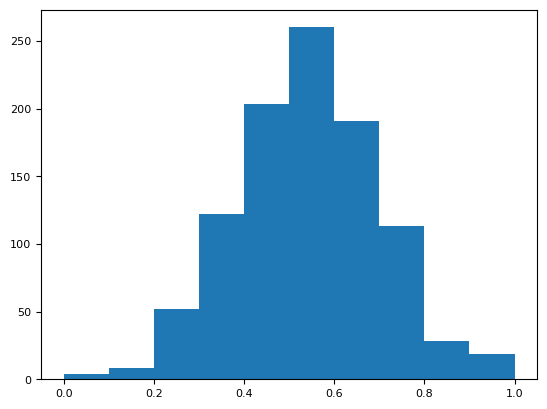

In [337]:
plt.hist(n1)

In [338]:
h1

(array([0.1, 0. , 0. , 0.1, 0. , 0. , 0.2, 0. , 0. , 0. , 0. , 0.1, 0. ,
        0.2, 0. , 0.1, 0.1, 0.1, 0.2, 0. , 0.6, 0.5, 0.7, 0. , 0.3, 0.6,
        0.6, 0.5, 0.9, 0.5, 0.6, 1.1, 0.9, 1. , 1.3, 1.4, 1.3, 2. , 1.1,
        1.5, 1.4, 2. , 1.8, 1.8, 1.6, 2.4, 2.4, 1.9, 2.6, 2.4, 3.2, 2.3,
        2.3, 2.9, 2.3, 2.2, 2.6, 3. , 2.9, 2.3, 1.6, 1.9, 2.8, 2.3, 2.7,
        2. , 1.3, 1.9, 1.4, 1.2, 1.5, 1.4, 1.1, 1.5, 1.4, 0.9, 0.8, 1. ,
        0.9, 0.8, 0.5, 0.3, 0.5, 0.1, 0.1, 0.4, 0.3, 0.1, 0.3, 0.2, 0.3,
        0.4, 0.2, 0.1, 0.2, 0.2, 0.2, 0. , 0. , 0.3]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
        0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.

In [339]:
color

[(0.9893886966551326, 0.8717416378316032, 0.8025374855824683, 1.0),
 (0.913033448673587, 0.5462514417531718, 0.43237216455209526, 1.0),
 (0.5769319492502883, 0.05536332179930796, 0.14925028835063436, 1.0),
 (0.48465974625144176, 0.02583621683967705, 0.1344867358708189, 1.0),
 (0.9783160322952711, 0.9234140715109573, 0.891118800461361, 1.0),
 (0.0368319876970396, 0.22145328719723184, 0.4265282583621684, 1.0),
 (0.7893886966551327, 0.2768166089965398, 0.2549019607843137, 1.0),
 (0.6807381776239907, 0.08858131487889273, 0.16585928489042678, 1.0),
 (0.8312956555171089, 0.9035755478662054, 0.9433294886582084, 1.0)]

9.75450000000011 0.13299296192358188521 s (0.9893886966551326, 0.8717416378316032, 0.8025374855824683, 1.0)
10.110000000000063 0.1766682501377618103 ^ (0.913033448673587, 0.5462514417531718, 0.43237216455209526, 1.0)
9.21100000000008 0.01750761984972397427 ^ (0.5769319492502883, 0.05536332179930796, 0.14925028835063436, 1.0)
9.406999999999943 0.047261123854578729764 s (0.48465974625144176, 0.02583621683967705, 0.1344867358708189, 1.0)
9.798500000000043 0.06803779264092982493 o (0.9783160322952711, 0.9234140715109573, 0.891118800461361, 1.0)
9.287000000000045 0.08046417215247008694 v (0.0368319876970396, 0.22145328719723184, 0.4265282583621684, 1.0)
10.155499999999984 0.16884221825125710889 v (0.7893886966551327, 0.2768166089965398, 0.2549019607843137, 1.0)
10.129999999999972 0.12570298301039901944 o (0.6807381776239907, 0.08858131487889273, 0.16585928489042678, 1.0)
10.383500000000101 0.2724774572502771762 o (0.8312956555171089, 0.9035755478662054, 0.9433294886582084, 1.0)
9.7545000000

/tmp/ipykernel_1724672/3786705520.py:6: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.2)
/tmp/ipykernel_1724672/3786705520.py:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(e,p,c=c,s=90,marker=m,edgecolors='black')


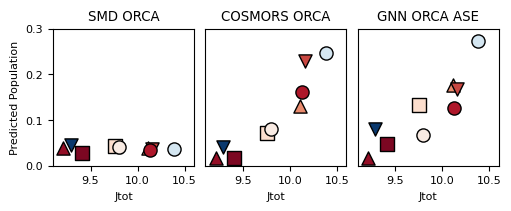

In [340]:
plt.rcParams.update({'font.size': 8})
fig, axd = plt.subplot_mosaic([["SMD ORCA","COSMORS ORCA","GNN ORCA ASE"]],figsize=(5,2),constrained_layout=True,empty_sentinel="EMPTY")
# set font size

# set vertical distance between subplots
plt.subplots_adjust(hspace=0.2)

def plot_comp(ax,min_populations):
    for e,p,m,c in zip(exp_J_sum,min_populations,markers,color):
        print(e,p,m,c)
        ax.scatter(e,p,c=c,s=90,marker=m,edgecolors='black')
    # ax.scatter(exp_J_sum,min_populations,c=color,s=90,marker=markers,edgecolors='black')
    # ax.errorbar(min_populations,Js,xerr=populations_std,fmt='o',color='black',zorder=0)
    ax.set_ylabel("Predicted Population of trans rotamer")
    ax.set_xlabel("JHH + JHH' Coupling (Hz)")
    # ax.set_title("GNN")

plot_comp(axd["GNN ORCA ASE"],gnn_results_orca_ase_populations)
plot_comp(axd["SMD ORCA"],smd_results_orca_populations)
plot_comp(axd["COSMORS ORCA"],cosmors_results_orca_populations)

axd["GNN ORCA ASE"].set_title("GNN ORCA ASE")
axd["SMD ORCA"].set_title("SMD ORCA")
axd["COSMORS ORCA"].set_title("COSMORS ORCA")

for ax in axd.values():
    ax.set_ylabel("Predicted Population")
    ax.set_xlabel("Jtot")
    ax.set_ylim(0,0.3)
    ax.set_xlim(9.1,10.6)
    ax.get_yaxis().set_visible(False)
    ax.set_yticks([0,0.1,0.2,0.3])
    # Set box size equal
    # ax.set_aspect('equal', 'box')
axd["SMD ORCA"].get_yaxis().set_visible(True)

# fig.savefig("Draft_Figures/populations_BP86_SVP_JHH.pdf",bbox_inches='tight')
fig.savefig(f"{figure_location}/populations_B3LYP_TZVP_JHH_i.pdf",bbox_inches='tight')

/tmp/ipykernel_1724672/2267710698.py:6: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.2)
/tmp/ipykernel_1724672/2267710698.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(p,e,c=c,s=90,marker=m,edgecolors='black')


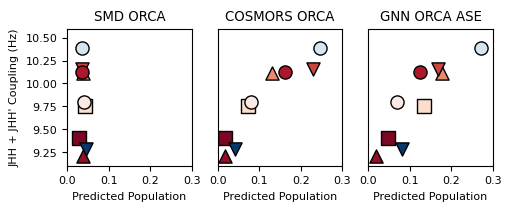

In [341]:
plt.rcParams.update({'font.size': 8})
fig, axd = plt.subplot_mosaic([["SMD ORCA","COSMORS ORCA","GNN ORCA ASE"]],figsize=(5,2),constrained_layout=True,empty_sentinel="EMPTY")
# set font size

# set vertical distance between subplots
plt.subplots_adjust(hspace=0.2)

def plot_comp(ax,min_populations):
    for e,p,m,c in zip(exp_J_sum,min_populations,markers,color):
        ax.scatter(p,e,c=c,s=90,marker=m,edgecolors='black')
    # ax.scatter(exp_J_sum,min_populations,c=color,s=90,marker=markers,edgecolors='black')
    # ax.errorbar(min_populations,Js,xerr=populations_std,fmt='o',color='black',zorder=0)
    ax.set_ylabel("Predicted Population of trans rotamer")
    ax.set_xlabel("JHH + JHH' Coupling (Hz)")
    # ax.set_title("GNN")

plot_comp(axd["GNN ORCA ASE"],gnn_results_orca_ase_populations)
plot_comp(axd["SMD ORCA"],smd_results_orca_populations)
plot_comp(axd["COSMORS ORCA"],cosmors_results_orca_populations)

axd["GNN ORCA ASE"].set_title("GNN ORCA ASE")
axd["SMD ORCA"].set_title("SMD ORCA")
axd["COSMORS ORCA"].set_title("COSMORS ORCA")

for ax in axd.values():
    ax.set_xlabel("Predicted Population")
    ax.set_ylabel("JHH + JHH' Coupling (Hz)")
    ax.set_xlim(0,0.3)
    ax.set_ylim(9.1,10.6)
    ax.get_yaxis().set_visible(False)
    # Set box size equal
    # ax.set_aspect('equal', 'box')
axd["SMD ORCA"].get_yaxis().set_visible(True)

# fig.savefig("Draft_Figures/populations_BP86_SVP_JHH.pdf",bbox_inches='tight')
fig.savefig(f"{figure_location}/populations_B3LYP_TZVP_JHH.pdf",bbox_inches='tight')

## Estimate Jg and Jt

In [342]:
GNN_JgJt = fit_JHHs(np.array(gnn_results_orca_ase_populations),exp_J_sum)
SMD_JgJt = fit_JHHs(np.array(smd_results_orca_populations),exp_J_sum)
COSMORS_JgJt = fit_JHHs(np.array(cosmors_results_orca_populations),exp_J_sum)

In [343]:
print(SMD_JgJt)
print(COSMORS_JgJt)
print(GNN_JgJt)

[ 15.30829185 -24.79316564]
[ 2.37669619 11.47284442]
[ 2.22501512 11.77644123]


## Predict IR spectrum

In [348]:
gnn_results_ORCA_ASE.keys()

dict_keys(['water', 'chloroform', 'methanol', 'dmso', 'benzene', 'thf', 'acetonitrile', 'pyridine', 'acetone', 'diethylether', 'dioxane'])

/tmp/ipykernel_1724672/4222892456.py:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  broadened_frequencies[i] += gaussian(frequency_range,np.float(f),5) * populations[i]
/tmp/ipykernel_1724672/4222892456.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  broadened_frequencies[i] += gaussian(frequency_range,np.float(f),5) * populations[i]


132
132


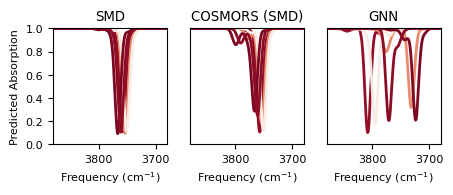

In [347]:
fig,axd = plt.subplot_mosaic([["SMD","SMD COSMORS","GNN"]],figsize=(5,1.5))

def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def plot_spectrum(frequencies,populations,color,ax):

    frequency_range = np.linspace(0,3900,5000)

    broadened_frequencies = np.zeros((len(frequencies),len(frequency_range)))
    for i,freq in enumerate(frequencies):
        for f in freq[-1:]:
            broadened_frequencies[i] += gaussian(frequency_range,np.float(f),5) * populations[i]

    broadened_frequencies = broadened_frequencies.T

    summed_spectrum = np.sum(broadened_frequencies,axis=1)
    # summed_spectrum = summed_spectrum/np.max(summed_spectrum)

    ax.plot(frequency_range,1-summed_spectrum,color=color,linewidth=2)
    return np.argmin(1-summed_spectrum) * (3900/5000)

free_energies = gnn_results_ORCA_ASE["chloroform"][1]
frequencies = gnn_results_ORCA_ASE["chloroform"][3]
populations = kjmol_to_prop(np.array(free_energies) - np.min(free_energies))
chloroform_IR = plot_spectrum(frequencies,populations,color=get_color_from_sd(SOLVENT_DICT["Chloroform"]["dielectric"]),ax=axd["GNN"])

free_energies = gnn_results_ORCA_ASE["acetone"][1]
frequencies = gnn_results_ORCA_ASE["acetone"][3]
populations = kjmol_to_prop(np.array(free_energies) - np.min(free_energies))
acetone_IR = plot_spectrum(frequencies,populations,color=get_color_from_sd(SOLVENT_DICT["acetone"]["dielectric"]),ax=axd["GNN"])

free_energies = gnn_results_ORCA_ASE["acetonitrile"][1]
frequencies = gnn_results_ORCA_ASE["acetonitrile"][3]
populations = kjmol_to_prop(np.array(free_energies) - np.min(free_energies))
acetonitrile_IR = plot_spectrum(frequencies,populations,color=get_color_from_sd(SOLVENT_DICT["acetonitrile"]["dielectric"]),ax=axd["GNN"])

free_energies = gnn_results_ORCA_ASE["dioxane"][1]
frequencies = gnn_results_ORCA_ASE["dioxane"][3]
populations = kjmol_to_prop(np.array(free_energies) - np.min(free_energies))
dioxane_IR = plot_spectrum(frequencies,populations,color=get_color_from_sd(SOLVENT_DICT["14dioxane"]["dielectric"]),ax=axd["GNN"])

free_energies = gnn_results_ORCA_ASE["diethylether"][1]
frequencies = gnn_results_ORCA_ASE["diethylether"][3]
populations = kjmol_to_prop(np.array(free_energies) - np.min(free_energies))
diethylether_IR = plot_spectrum(frequencies,populations,color=get_color_from_sd(SOLVENT_DICT["Diethylether"]["dielectric"]),ax=axd["GNN"])

free_energies = smd_results_ORCA["chloroform"][1]
frequencies = smd_results_ORCA["chloroform"][3]
populations = kjmol_to_prop(np.array(free_energies) - np.min(free_energies))
chloroform_IR_SMD = plot_spectrum(frequencies,populations,color=get_color_from_sd(SOLVENT_DICT["Chloroform"]["dielectric"]),ax=axd["SMD"])

free_energies = smd_results_ORCA["acetone"][1]
frequencies = smd_results_ORCA["acetone"][3]
populations = kjmol_to_prop(np.array(free_energies) - np.min(free_energies))
acetone_IR_SMD = plot_spectrum(frequencies,populations,color=get_color_from_sd(SOLVENT_DICT["acetone"]["dielectric"]),ax=axd["SMD"])

free_energies = smd_results_ORCA["acetonitrile"][1]
frequencies = smd_results_ORCA["acetonitrile"][3]
populations = kjmol_to_prop(np.array(free_energies) - np.min(free_energies))
acetonitrile_IR_SMD = plot_spectrum(frequencies,populations,color=get_color_from_sd(SOLVENT_DICT["acetonitrile"]["dielectric"]),ax=axd["SMD"])

free_energies = smd_results_ORCA["dioxane"][1]
frequencies = smd_results_ORCA["dioxane"][3]
populations = kjmol_to_prop(np.array(free_energies) - np.min(free_energies))
dioxane_IR_SMD = plot_spectrum(frequencies,populations,color=get_color_from_sd(SOLVENT_DICT["14dioxane"]["dielectric"]),ax=axd["SMD"])

free_energies = smd_results_ORCA["diethylether"][1]
frequencies = smd_results_ORCA["diethylether"][3]
populations = kjmol_to_prop(np.array(free_energies) - np.min(free_energies))
diethylether_IR_SMD = plot_spectrum(frequencies,populations,color=get_color_from_sd(SOLVENT_DICT["Diethylether"]["dielectric"]),ax=axd["SMD"])

free_energies = cosmors_results_ORCA["chloroform"][1]
frequencies = cosmors_results_ORCA["chloroform"][3]
populations = kjmol_to_prop(np.array(free_energies) - np.min(free_energies))
chloroform_IR_COSMORS = plot_spectrum(frequencies,populations,color=get_color_from_sd(SOLVENT_DICT["Chloroform"]["dielectric"]),ax=axd["SMD COSMORS"])

free_energies = cosmors_results_ORCA["acetone"][1]
frequencies = cosmors_results_ORCA["acetone"][3]
populations = kjmol_to_prop(np.array(free_energies) - np.min(free_energies))
acetone_IR_COSMORS = plot_spectrum(frequencies,populations,color=get_color_from_sd(SOLVENT_DICT["acetone"]["dielectric"]),ax=axd["SMD COSMORS"])

free_energies = cosmors_results_ORCA["acetonitrile"][1]
frequencies = cosmors_results_ORCA["acetonitrile"][3]
populations = kjmol_to_prop(np.array(free_energies) - np.min(free_energies))
acetonitrile_IR_COSMORS = plot_spectrum(frequencies,populations,color=get_color_from_sd(SOLVENT_DICT["acetonitrile"]["dielectric"]),ax=axd["SMD COSMORS"])

free_energies = cosmors_results_ORCA["dioxane"][1]
frequencies = cosmors_results_ORCA["dioxane"][3]
populations = kjmol_to_prop(np.array(free_energies) - np.min(free_energies))
dioxane_IR_COSMORS = plot_spectrum(frequencies,populations,color=get_color_from_sd(SOLVENT_DICT["14dioxane"]["dielectric"]),ax=axd["SMD COSMORS"])

free_energies = cosmors_results_ORCA["diethylether"][1]
frequencies = cosmors_results_ORCA["diethylether"][3]
print(len(free_energies))
print(len(cosmors_results_ORCA["diethylether"][3]))
populations = kjmol_to_prop(np.array(free_energies) - np.min(free_energies))
diethylether_IR_COSMORS = plot_spectrum(frequencies,populations,color=get_color_from_sd(SOLVENT_DICT["Diethylether"]["dielectric"]),ax=axd["SMD COSMORS"])

axd["GNN"].set_title("GNN")
axd["SMD"].set_title("SMD")
# axd["CPCM"].set_title("CPCM")
axd["SMD COSMORS"].set_title("COSMORS (SMD)")

axd["GNN"].get_yaxis().set_visible(False)
# axd["CPCM"].get_yaxis().set_visible(False)
axd["SMD COSMORS"].get_yaxis().set_visible(False)

for ax in axd.values():
    ax.set_xlim(3880,3680)
    ax.set_ylim(0,1)
    ax.set_xlabel("Frequency (cm$^{-1}$)")
    ax.set_ylabel("Predicted Absorption")
    # ax.legend(["Chloroform","Acetone","Acetonitrile","Dioxane","Diethylether"],loc="upper right")
fig.savefig(f"{figure_location}/IR_B3LYP_TZVP.pdf",bbox_inches='tight')

In [208]:
marker_dict.keys()

dict_keys(['water', 'chloroform', 'methanol', 'dmso', 'benzene', 'thf', 'acetonitrile', 'pyridine', 'acetone', 'diethylether', 'dioxane', 'hexane'])

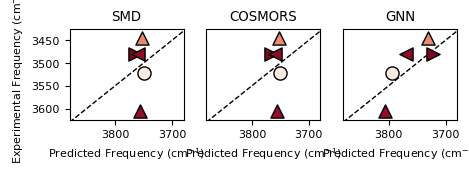

In [209]:
experitmental_IR = {"chloroform":3606,"acetone":3445,"acetonitrile":3522,"dioxane":3480,"diethylether":3480}
colors = [get_color_from_sd(SOLVENT_DICT[solvent]["dielectric"]) for solvent in ["Chloroform","acetone","acetonitrile","14dioxane","Diethylether"]]

pre_gnn = [chloroform_IR,acetone_IR,acetonitrile_IR,dioxane_IR,diethylether_IR]
pre_smd = [chloroform_IR_SMD,acetone_IR_SMD,acetonitrile_IR_SMD,dioxane_IR_SMD,diethylether_IR_SMD]
pre_cosmors = [chloroform_IR_COSMORS,acetone_IR_COSMORS,acetonitrile_IR_COSMORS,dioxane_IR_COSMORS,diethylether_IR_COSMORS]
exp = [experitmental_IR[solvent] for solvent in ["chloroform","acetone","acetonitrile","dioxane","diethylether"]]

fig,axd = plt.subplot_mosaic([["SMD","COSMORS","GNN"]],figsize=(5,2.5))

markers = [marker_dict[solvent] for solvent in ["chloroform","acetone","acetonitrile","dioxane","diethylether"]]

for e,p_gnn,p_smd,p_cosmors, c,m in zip(exp,pre_gnn,pre_smd,pre_cosmors,colors,markers):
    axd["GNN"].scatter(p_gnn,e,color=c,s=90,marker=m,edgecolors='black')
    axd["SMD"].scatter(p_smd,e,color=c,s=90,marker=m,edgecolors='black')
    axd["COSMORS"].scatter(p_cosmors,e,color=c,s=90,marker=m,edgecolors='black')

# axd["GNN"].scatter(exp,pre_gnn,color=colors,s=90,marker='o',edgecolors='black')
# axd["SMD"].scatter(exp,pre_smd,color=colors,s=90,marker='o',edgecolors='black')
# axd["COSMORS"].scatter(exp,pre_cosmors,color=colors,s=90,marker='o',edgecolors='black')

axd["GNN"].set_title("GNN")
axd["SMD"].set_title("SMD")
axd["COSMORS"].set_title("COSMORS")

for ax in axd.values():
    ax.set_ylim(3625,3425)
    ax.set_xlim(3880,3680)
    ax.plot([3880,3680],[3630,3430],color="black",linestyle="--",linewidth=1,zorder=0)
    ax.set_xlabel("Predicted Frequency (cm$^{-1}$)")
    ax.set_ylabel("Experimental Frequency (cm$^{-1}$)")
    ax.get_yaxis().set_visible(False)
    ax.set_box_aspect(0.8)
axd["SMD"].get_yaxis().set_visible(True)
fig.savefig(f"{figure_location}/IR_B3LYP_TZVP_Frequencies_i.pdf",bbox_inches='tight')

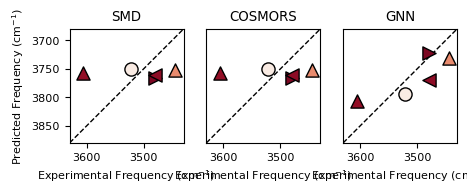

In [210]:
experitmental_IR = {"chloroform":3606,"acetone":3445,"acetonitrile":3522,"dioxane":3480,"diethylether":3480}
colors = [get_color_from_sd(SOLVENT_DICT[solvent]["dielectric"]) for solvent in ["Chloroform","acetone","acetonitrile","14dioxane","Diethylether"]]

pre_gnn = [chloroform_IR,acetone_IR,acetonitrile_IR,dioxane_IR,diethylether_IR]
pre_smd = [chloroform_IR_SMD,acetone_IR_SMD,acetonitrile_IR_SMD,dioxane_IR_SMD,diethylether_IR_SMD]
pre_cosmors = [chloroform_IR_COSMORS,acetone_IR_COSMORS,acetonitrile_IR_COSMORS,dioxane_IR_COSMORS,diethylether_IR_COSMORS]
exp = [experitmental_IR[solvent] for solvent in ["chloroform","acetone","acetonitrile","dioxane","diethylether"]]

fig,axd = plt.subplot_mosaic([["SMD","COSMORS","GNN"]],figsize=(5,2.5))

markers = [marker_dict[solvent] for solvent in ["chloroform","acetone","acetonitrile","dioxane","diethylether"]]

for e,p_gnn,p_smd,p_cosmors, c,m in zip(exp,pre_gnn,pre_smd,pre_cosmors,colors,markers):
    axd["GNN"].scatter(e,p_gnn,color=c,s=90,marker=m,edgecolors='black')
    axd["SMD"].scatter(e,p_smd,color=c,s=90,marker=m,edgecolors='black')
    axd["COSMORS"].scatter(e,p_cosmors,color=c,s=90,marker=m,edgecolors='black')

# axd["GNN"].scatter(exp,pre_gnn,color=colors,s=90,marker='o',edgecolors='black')
# axd["SMD"].scatter(exp,pre_smd,color=colors,s=90,marker='o',edgecolors='black')
# axd["COSMORS"].scatter(exp,pre_cosmors,color=colors,s=90,marker='o',edgecolors='black')

axd["GNN"].set_title("GNN")
axd["SMD"].set_title("SMD")
axd["COSMORS"].set_title("COSMORS")

for ax in axd.values():
    ax.set_xlim(3630,3430)
    ax.set_ylim(3880,3680)
    ax.plot([3630,3430],[3880,3680],color="black",linestyle="--",linewidth=1,zorder=0)
    ax.set_ylabel("Predicted Frequency (cm$^{-1}$)")
    ax.set_xlabel("Experimental Frequency (cm$^{-1}$)")
    ax.get_yaxis().set_visible(False)
    ax.set_box_aspect(1)
axd["SMD"].get_yaxis().set_visible(True)
fig.savefig(f"{figure_location}/IR_B3LYP_TZVP_Frequencies.pdf",bbox_inches='tight')

## Compound I4

In [211]:
smiles = "COCCOC"
functional = "_SMD_B3LYP_TZVP"
# functional = ""
folder = f"/fileserver/birch/birch1/kpaul/pine8/QMGNN/I4_start_orca_min_hessian_no_mpi{functional}_f025/"
nconfs = 1

solvent_mapping = {
    "water": "tip3p",
    "chloroform": "Chloroform",
    "methanol": "Methanol",
    "dmso": "DMSO",
    "benzene": "Benzol",
    "thf": "THF",
    "acetonitrile": "acetonitrile",
    "pyridine": "pyridine",
    "acetone": "acetone",
    "diethylether": "Diethylether",
    "dioxane": "14dioxane",
    "hexane": "Hexan",
}

gnn_results_ORCA_ASE = {}
gnn_results_ORCA = {}
smd_results_ORCA = {}
gnn_smd_results_ORCA = {}
cosmors_results_ORCA = {}

for solvent in solvent_mapping.keys():
    try:
        def get_results(folder,solvent,nconfs,method):
            free_energies = []
            positions = []
            frequencies = []

            mol = Chem.MolFromSmiles(smiles)
            mol = Chem.AddHs(mol)
            AllChem.EmbedMolecule(mol)
            traj = mol_to_traj(mol)
            
            for seed in range(256):
                try:
                    results = np.load(f"{folder}/{solvent}_{seed}.npy",allow_pickle=True)
                except Exception as e:
                    print(e)
                    continue

                if method == "gnn_orca":
                    free_energies.append(results[0][3])
                    positions.append(results[0][0])
                elif method == "cosmors_orca":
                    hessian = results[0][4]*96.485332
                    masses = np.array([atom.GetMass() for atom in mol.GetAtoms()]).round(0)
                    idices = [atom.GetIdx() for atom in mol.GetAtoms()]
                    freqs, nm = normal_modes(hessian, idices, masses)
                    if np.sum(np.iscomplex(freqs)) != 0: # Complex Frequency
                        continue
                    free_energies.append(results[0][2])
                    positions.append(results[0][0])
                    # Add Frequencies
                    frequencies.append(freqs)

                elif method == "smd_orca":
                    hessian = results[0][4]*96.485332
                    masses = np.array([atom.GetMass() for atom in mol.GetAtoms()]).round(0)
                    idices = [atom.GetIdx() for atom in mol.GetAtoms()]
                    freqs, nm = normal_modes(hessian, idices, masses)
                    if np.sum(np.iscomplex(freqs)) != 0: # Complex Frequency
                        continue
                    frequencies.append(freqs)
                    free_energies.append(results[0][1])
                    positions.append(results[0][0])
                elif method == "gnn_orca_ase":
                    pos = results[0][8]

                    hessian = results[0,10]*96.485332 + results[0,11]
                    masses = np.array([atom.GetMass() for atom in mol.GetAtoms()]).round(0)
                    idices = [atom.GetIdx() for atom in mol.GetAtoms()]
                    freqs, nm = normal_modes(hessian, idices, masses)
                    # test if any freqs is complex
                    if np.sum(np.iscomplex(freqs)) != 0: # Complex Frequency
                        continue
                    vib_entropy = calculate_entropy_from_frequencies(freqs)
                    free_energy = results[0,12] - vib_entropy
                    positions.append(results[0][8])
                    free_energies.append(free_energy)
                    frequencies.append(freqs)
                elif method == "gnn_smd_orca":
                    free_energies.append(results[0][6])
                    positions.append(results[0][0])

            energies = np.array(free_energies)
            energies[energies < np.median(energies[energies != np.inf])*1.5] = np.inf
            traj.xyz = np.array(positions)[energies != np.inf]
            energies = energies[energies != np.inf]

            # all atom RMSD
            selection = [traj.top.select("all")]
            print(selection)
            cluster_traj, cluster_energies = get_cluster_asignments_ordered(traj=traj,energies=energies,energy_thresh=100,thresh=0.05,permutations=selection,selection=selection[0])

            # get indices of cluster_energies based on energies
            indices = [np.argwhere(energies == e)[0][0] for e in cluster_energies]
            if len(frequencies) > 0:
                frequencies = np.array(frequencies)[indices]
            dh = get_dihedrals_by_name(cluster_traj, "O1","C2","C3","O2").flatten()
            return (dh, cluster_energies, cluster_traj,frequencies)

        gnn_results_ORCA_ASE[solvent] = get_results(folder,solvent,nconfs,"gnn_orca_ase")
        gnn_results_ORCA[solvent] = get_results(folder,solvent,nconfs,"gnn_orca")
        smd_results_ORCA[solvent] = get_results(folder,solvent,nconfs,"smd_orca")
        gnn_smd_results_ORCA[solvent] = get_results(folder,solvent,nconfs,"gnn_smd_orca")
        cosmors_results_ORCA[solvent] = get_results(folder,solvent,nconfs,"cosmors_orca")
    except Exception as e:
        print(e)
        continue

[Errno 2] No such file or directory: '/fileserver/birch/birch1/kpaul/pine8/QMGNN/I4_start_orca_min_hessian_no_mpi_SMD_B3LYP_TZVP_f025//water_255.npy'
[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])]
[Errno 2] No such file or directory: '/fileserver/birch/birch1/kpaul/pine8/QMGNN/I4_start_orca_min_hessian_no_mpi_SMD_B3LYP_TZVP_f025//water_255.npy'
[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])]
[Errno 2] No such file or directory: '/fileserver/birch/birch1/kpaul/pine8/QMGNN/I4_start_orca_min_hessian_no_mpi_SMD_B3LYP_TZVP_f025//water_255.npy'
[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])]
[Errno 2] No such file or directory: '/fileserver/birch/birch1/kpaul/pine8/QMGNN/I4_start_orca_min_hessian_no_mpi_SMD_B3LYP_TZVP_f025//water_255.npy'
[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])]
[Errno 2] No such file or directory: '/fileserver/birch/birch1/kpaul/pine8/QMGNN/I4_start_orca_min_hessi

/localhome/kpaul/.conda/envs/QMGNN/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/localhome/kpaul/.conda/envs/QMGNN/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[Errno 2] No such file or directory: '/fileserver/birch/birch1/kpaul/pine8/QMGNN/I4_start_orca_min_hessian_no_mpi_SMD_B3LYP_TZVP_f025//hexane_255.npy'
[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])]
[Errno 2] No such file or directory: '/fileserver/birch/birch1/kpaul/pine8/QMGNN/I4_start_orca_min_hessian_no_mpi_SMD_B3LYP_TZVP_f025//hexane_255.npy'
[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])]
[Errno 2] No such file or directory: '/fileserver/birch/birch1/kpaul/pine8/QMGNN/I4_start_orca_min_hessian_no_mpi_SMD_B3LYP_TZVP_f025//hexane_255.npy'
[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])]
[Errno 2] No such file or directory: '/fileserver/birch/birch1/kpaul/pine8/QMGNN/I4_start_orca_min_hessian_no_mpi_SMD_B3LYP_TZVP_f025//hexane_255.npy'
[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])]
[Errno 2] No such file or directory: '/fileserver/birch/birch1/kpaul/pine8/QMGNN/I4_start_orca_min_h

In [212]:
len(gnn_results_ORCA_ASE["water"])

4

In [213]:
reference_J_couplings_n = {"Methanol":  9.43,"Chloroform":9.45,"tip3p":9.25,"DMSO":9.71,"Hexan":10.33}
reference_J_couplings = {"methanol":  9.43,"chloroform":9.45,"water":9.25,"dmso":9.71,"hexane":10.33}

exp_J_sum = [np.sum(ref) for ref in reference_J_couplings.values()]
color = [get_color_from_sd(SOLVENT_DICT[solvent]["dielectric"]) for solvent in reference_J_couplings_n.keys()]
names = [solvent for solvent in reference_J_couplings_n.keys()]

def get_populations(solvent_results):

    min_populations = []
    for solvent in reference_J_couplings.keys():
        gnn_dh, cluster_energies, _, _ = solvent_results[solvent]
        selection = (gnn_dh < 2.1) & (gnn_dh > -2.1)
        min_pre = np.sum(kjmol_to_prop(np.array(cluster_energies)-np.min(cluster_energies))[selection.flatten()])
        min_populations.append(1-min_pre)
    
    return min_populations

gnn_populations = get_populations(gnn_results_ORCA_ASE)
cosmors_populations = get_populations(cosmors_results_ORCA)
smd_populations = get_populations(smd_results_ORCA)
exp_J_sum = [ref for ref in reference_J_couplings.values()]
color = [get_color_from_sd(SOLVENT_DICT[solvent]["dielectric"]) for solvent in reference_J_couplings_n.keys()]

/tmp/ipykernel_1724672/2570700536.py:6: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.2)


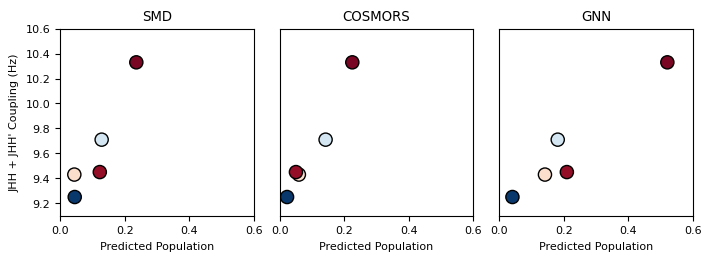

In [214]:
plt.rcParams.update({'font.size': 8})
fig, axd = plt.subplot_mosaic([["SMD ORCA","COSMORS ORCA","GNN ORCA ASE"]],figsize=(7,2.5),constrained_layout=True,empty_sentinel="EMPTY")
# set font size

# set vertical distance between subplots
plt.subplots_adjust(hspace=0.2)

def plot_comp(ax,min_populations):
    ax.scatter(min_populations,exp_J_sum,c=color,s=90,marker='o',edgecolors='black')
    # ax.errorbar(min_populations,Js,xerr=populations_std,fmt='o',color='black',zorder=0)
    ax.set_xlabel("Predicted Population of trans rotamer")
    ax.set_ylabel("JHH + JHH' Coupling (Hz)")
    # ax.set_title("GNN")

    # for i in range(len(min_populations)):

    #     shifty=0.015
    #     shiftx=0.002
    #     if names[i] == "acetonitrile":
    #         shifty = -0.095
    #         shiftx = -0.001
    #     if names[i] == "acetone":
    #         shifty = 0.075
    #         shiftx = 0.005
    #     if names[i] == "THF":
    #         shifty = 0.02
    #         # shiftx = -0.014
    #     if names[i] == "pyridine":
    #         shiftx = -0.00
    #         # shifty = -0.12
    #     if names[i] == "DMSO":
    #         shifty = 0.05
    #         shiftx = -0.001
    #     ax.text(min_populations[i]+0.002+shiftx,exp_J_sum[i]+shifty,SOLVENT_DICT[names[i]]["nice_name"],fontsize=8)

plot_comp(axd["GNN ORCA ASE"],gnn_populations)
plot_comp(axd["SMD ORCA"],smd_populations)
plot_comp(axd["COSMORS ORCA"],cosmors_populations)

axd["GNN ORCA ASE"].set_title("GNN")
axd["SMD ORCA"].set_title("SMD")
axd["COSMORS ORCA"].set_title("COSMORS")

for ax in axd.values():
    ax.set_xlabel("Predicted Population")
    ax.set_ylabel("JHH + JHH' Coupling (Hz)")
    ax.set_xlim(0,0.6)
    ax.set_ylim(9.1,10.6)
    ax.get_yaxis().set_visible(False)
axd["SMD ORCA"].get_yaxis().set_visible(True)

# fig.savefig("Draft_Figures/populations_BP86_SVP_JHH.pdf",bbox_inches='tight')
fig.savefig(f"{figure_location}/populations_B3LYP_TZVP_JHH_I4.pdf",bbox_inches='tight')

/tmp/ipykernel_1724672/64660422.py:6: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.2)
/tmp/ipykernel_1724672/64660422.py:12: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(e,p,c=c,s=90,marker=m,edgecolors='black')


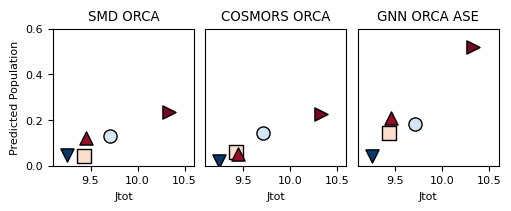

In [219]:
plt.rcParams.update({'font.size': 8})
fig, axd = plt.subplot_mosaic([["SMD ORCA","COSMORS ORCA","GNN ORCA ASE"]],figsize=(5,2),constrained_layout=True,empty_sentinel="EMPTY")
# set font size

# set vertical distance between subplots
plt.subplots_adjust(hspace=0.2)

markers = np.array([marker_dict[solvent] for solvent in reference_J_couplings.keys()])

def plot_comp(ax,min_populations):
    for e,p,m,c in zip(exp_J_sum,min_populations,markers,color):
        ax.scatter(e,p,c=c,s=90,marker=m,edgecolors='black')
    # ax.scatter(exp_J_sum,min_populations,c=color,s=90,marker='o',edgecolors='black')
    # ax.errorbar(min_populations,Js,xerr=populations_std,fmt='o',color='black',zorder=0)
    ax.set_xlabel("Predicted Population of trans rotamer")
    ax.set_ylabel("JHH + JHH' Coupling (Hz)")



plot_comp(axd["GNN ORCA ASE"],gnn_populations)
plot_comp(axd["SMD ORCA"],smd_populations)
plot_comp(axd["COSMORS ORCA"],cosmors_populations)

# axd["GNN ORCA ASE"].set_title("GNN")
# axd["SMD ORCA"].set_title("SMD")
# axd["COSMORS ORCA"].set_title("COSMORS")

axd["GNN ORCA ASE"].set_title("GNN ORCA ASE")
axd["SMD ORCA"].set_title("SMD ORCA")
axd["COSMORS ORCA"].set_title("COSMORS ORCA")

for ax in axd.values():
    ax.set_ylabel("Predicted Population")
    ax.set_xlabel("Jtot")
    ax.set_ylim(0,0.6)
    ax.set_xlim(9.1,10.6)
    ax.get_yaxis().set_visible(False)
    # ax.set_box_aspect(1)
    ax.set_yticks([0,0.2,0.4,0.6])
axd["SMD ORCA"].get_yaxis().set_visible(True)

# fig.savefig("Draft_Figures/populations_BP86_SVP_JHH.pdf",bbox_inches='tight')
fig.savefig(f"{figure_location}/populations_B3LYP_TZVP_JHH_I4_i.pdf",bbox_inches='tight')

## Make Fit

In [140]:
GNN_JgJt = fit_JHHs(np.array(gnn_populations),exp_J_sum)
SMD_JgJt = fit_JHHs(np.array(smd_populations),exp_J_sum)
COSMORS_JgJt = fit_JHHs(np.array(cosmors_populations),exp_J_sum)

print(SMD_JgJt)
print(COSMORS_JgJt)
print(GNN_JgJt)

[ 2.00723554 12.08353849]
[ 2.07128434 12.05622797]
[3.44768143 7.94164563]
